# Rebuild MPI-GE

## Import Modules

In [11]:
# General imports
import numpy as np
from tqdm import tqdm
import string
import re

# Data handling imports
import xarray as xr

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Statistics imports
from scipy import stats 
from scipy.stats import norm
from statsmodels.regression.linear_model import yule_walker
import statsmodels.api as sm

# Custom imports
from   functions.variables import cc_ssps
import functions.helper as hlp
import functions.siametadata as meta
import functions.memberhandling as mbhl
import functions.emulator_func as em

## Load Data

In [12]:
basepath = "/Users/quraus001/Documents/Uni/SIA-Sensitivity-Uncertainty/"

datapath = basepath + "data/"
plotpath = basepath + "plots/MPI-GE/"

save_plots = False

In [13]:
# Model data
DF = {}
for scenario in ["ssp245", "ssp370", "ssp585"]:
    DF[scenario] = mbhl.load_model_data(inpath=datapath + "MPI-ESM2-1-LR/sia_nh/", scenario=scenario)
members = list(DF[scenario].columns)[:-3]
members = sorted(members, key=lambda x: int(re.search(r'r(\d+)i', x).group(1)))

# CO2 Data
cmip6_ds = xr.open_dataset(datapath +"co2/CMIP6_co2_emissions_ssp.nc")
df_co2 = cmip6_ds.to_dataframe().cumsum(axis=0)
df_co2.index = df_co2.index.astype(int)
df_co2

,ssp119,ssp126,ssp245,ssp370,ssp585
time,,,,,
1850,2.665337,2.665337,2.665337,2.665337,2.665337
1851,5.350075,5.350075,5.350075,5.350075,5.350075
1852,8.061351,8.061351,8.061351,8.061351,8.061351
1853,10.800027,10.800027,10.800027,10.800027,10.800027
1854,13.588079,13.588079,13.588079,13.588079,13.588079
...,...,...,...,...,...
2096,2706.720558,3427.763601,5130.141688,7400.632679,9678.963999
2097,2693.828200,3419.215596,5141.817007,7481.880477,9806.537988
2098,2680.603365,3410.644331,5152.828173,7563.620953,9933.683084


In [14]:
def plot_hist_comparision(data1, data2, ax, bins, ymax, emulator_runs):
    ax_twin = ax.twinx()
    ax.hist(data1, color="dimgray", bins=bins, alpha=0.5, edgecolor="dimgray", linewidth=1.5)
    ax_twin.hist(data2, alpha=1, bins=bins, histtype="step", color="#2066BA", linewidth=1.5)
    ax_twin.hist(data2, alpha=0.2, bins=bins, color="#2066BA")
    print("       Mean, std, IQR, Skewness, Kurtosis")
    print(f"data1: {np.mean(data1):1.3f}, {np.std(data1):1.3f}, {stats.iqr(data1):1.3f}, {stats.skew(data1):1.3f}, {stats.kurtosis(data1):1.3f}")
    print(f"data2: {np.mean(data2):1.3f}, {np.std(data2):1.3f}, {stats.iqr(data2):1.3f}, {stats.skew(data2):1.3f}, {stats.kurtosis(data2):1.3f}")

    ax.set_ylim(0, ymax)
    ax_twin.set_ylim(0, ymax*emulator_runs/50)

    ax.set_ylabel(r"Number of MPI-GE members")
    ax_twin.set_ylabel(r"Number of emulator members")
    
    ax_twin.spines['top'].set_visible(False)
    ax_twin.spines['bottom'].set_visible(False)
    ax_twin.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax_twin

## Collect Mean Meta Data

In [19]:
start, stop = 1979, 2024


Lin_timings_MPI = {"ssp245":[],"ssp370":[],"ssp585":[]} # 50% ice-free timing
Sim_timings_MPI = {"ssp245":[],"ssp370":[],"ssp585":[]} # first ice-free timing
Obs_sens_MPI    = {"ssp245":[],"ssp370":[],"ssp585":[]} # sensitivity of "observation" period
Variability_MPI = {"ssp245":[],"ssp370":[],"ssp585":[]} # amplitude of internal variability #not spline corrected
AR1_coeff_MPI   = {"ssp245":[],"ssp370":[],"ssp585":[]} # autocorrelation coeffiecient #not spline corrected

Y_pred_MPI      = {"ssp245":[],"ssp370":[],"ssp585":[]} # linear component of regression
Intercept_MPI   = {"ssp245":[],"ssp370":[],"ssp585":[]} # intercept form the regression
Sim_timings_year_MPI = {"ssp245":[],"ssp370":[],"ssp585":[]} # year of first ice-free conditions
MEANS = {"ssp245":[],"ssp370":[],"ssp585":[]} # Dict for saving all the means

for scenario in ["ssp245", "ssp370", "ssp585"]:
    print(scenario.upper())

    for mb in members:
        sens, y_pred, lin_timing, intercept = meta.get_meta_data(DF[scenario].loc[start:stop][mb].values, df_co2.loc[start:stop][scenario].values)
        
        Lin_timings_MPI[scenario].append(lin_timing)
        Y_pred_MPI[scenario].append(y_pred)
        Intercept_MPI[scenario].append(intercept)
        Obs_sens_MPI[scenario].append(sens)

        icefree_year = DF[scenario][DF[scenario][mb] < 1].index[0]
        Sim_timings_year_MPI[scenario].append(icefree_year)
        Sim_timings_MPI[scenario].append(df_co2[scenario].loc[icefree_year])

        residuals = DF[scenario][mb].loc[start:stop] - y_pred
        Variability_MPI[scenario].append(np.std(residuals))

        rho, sigma = yule_walker(residuals, order=1)
        ar1_corrcoef = rho[0] + ((1+4*rho)/len(residuals))
        AR1_coeff_MPI[scenario].append(ar1_corrcoef.item())


    # Calculate Background Sensitivity    
    # Period is defined following Notz & Stroeve 2016
    reference  = np.nanmin(DF[scenario]["mean"].loc[1850:1900].values) # minimum value of 1850 to 1900
    start_full = DF[scenario].index[50 + np.where(DF[scenario]["mean"].loc[1900:].values <(reference*0.9))[0][0]]
    end_full   = int(np.mean(Sim_timings_year_MPI[scenario]))
    BS, y_pred, lin_timing, intercept = meta.get_meta_data(DF[scenario].loc[start_full:end_full]["mean"].values, df_co2.loc[start_full:end_full][scenario].values)

    # Print mean quantaties
    print(f"  Background Sensitivity ({start_full}-{end_full:.0f}): {BS:.2f} m2/t")
    print(f"  mean Sensitivity ({start}-{stop}):       {np.mean(Obs_sens_MPI[scenario]):.2f} m2/t")
    print(f"  mean Intercept   ({start}-{stop}):        {np.mean(Intercept_MPI[scenario]):.2f} km2")
    print()
    print(f"  mean Variability ({start}-{stop}):        {np.mean(Variability_MPI[scenario]):.2f} km2")
    print(f"  mean AR(1) coeff ({start}-{stop}):        {np.mean(AR1_coeff_MPI[scenario]):.2f} ")
    print()
    print(f"  mean first ice-free timing:          {np.mean(Sim_timings_MPI[scenario]):.0f} Gt")  
    print(f"  mean first ice-free timing year:     {np.mean(Sim_timings_year_MPI[scenario]):.0f}")  
    print(f"  mean exrtapolated timing:            {np.mean(Lin_timings_MPI[scenario]):.0f} Gt") 
    print()

    # Save mean quantaties
    MEANS[scenario] = {"sens":np.mean(Obs_sens_MPI[scenario]), 
                       "background_sens": BS, 
                       "ar1_coef": np.mean(AR1_coeff_MPI[scenario]),
                       "member_std": np.mean(Variability_MPI[scenario]),  
                       "lin_timing":np.mean(Lin_timings_MPI[scenario]), 
                       "sim_timing":np.mean(Sim_timings_MPI[scenario]), 
                       "sim_timing_year":int(np.mean(Sim_timings_year_MPI[scenario]))}


BS_all = (MEANS["ssp245"]["background_sens"] + MEANS["ssp370"]["background_sens"] + MEANS["ssp585"]["background_sens"])/3
print("True sensitivity", BS_all)  

SSP245
  Background Sensitivity (1974-2049): -1.25 m2/t
  mean Sensitivity (1979-2024):       -1.38 m2/t
  mean Intercept   (1979-2024):        6.31 km2

  mean Variability (1979-2024):        0.37 km2
  mean AR(1) coeff (1979-2024):        0.47 

  mean first ice-free timing:          3732 Gt
  mean first ice-free timing year:     2050
  mean exrtapolated timing:            3929 Gt

SSP370
  Background Sensitivity (1974-2046): -1.21 m2/t
  mean Sensitivity (1979-2024):       -1.35 m2/t
  mean Intercept   (1979-2024):        6.27 km2

  mean Variability (1979-2024):        0.37 km2
  mean AR(1) coeff (1979-2024):        0.49 

  mean first ice-free timing:          3898 Gt
  mean first ice-free timing year:     2046
  mean exrtapolated timing:            3993 Gt

SSP585
  Background Sensitivity (1974-2044): -1.22 m2/t
  mean Sensitivity (1979-2024):       -1.38 m2/t
  mean Intercept   (1979-2024):        6.31 km2

  mean Variability (1979-2024):        0.37 km2
  mean AR(1) coeff (1979

## Internal Variability

### Ensemble Spread

SSP245
  max spread of 0.539 in 2042
  mean spread last 10yrs before ice-free: 0.468
SSP370
  max spread of 0.536 in 2035
  mean spread last 10yrs before ice-free: 0.466
SSP585
  max spread of 0.547 in 2023
  mean spread last 10yrs before ice-free: 0.457


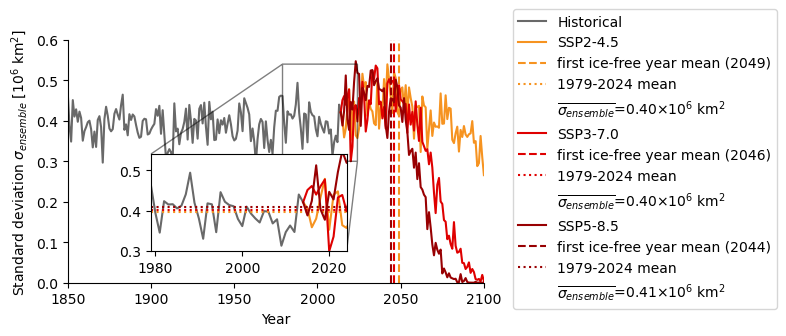

In [20]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)

Label = {"ssp245":"SSP2-4.5", "ssp370":"SSP3-7.0", "ssp585":"SSP5-8.5"}

# Create an inset axis for zooming into the satellite period
axins = ax.inset_axes([0.2, 0.13, 0.47, 0.4],xlim=(1979, 2024), ylim=(0.3, 0.54))

# Plot historical ensemble spread (std across members)
DF[scenario].iloc[:,:-3].loc[:2014].std(axis=1).plot(ax=ax, color=cc_ssps["historical"], label="Historical")
DF[scenario].iloc[:,:-3].loc[:2014].std(axis=1).plot(ax=axins, color=cc_ssps["historical"])

# Repeat for all SSPs
for scenario in ["ssp245", "ssp370", "ssp585"]:
    print(scenario.upper())

    mean_ice_free = MEANS[scenario]["sim_timing_year"]
    DF[scenario].loc[2014:].iloc[:,:-3].std(axis=1).plot(ax=ax, color=cc_ssps[scenario], label=Label[scenario])
    DF[scenario].loc[2014:].iloc[:,:-3].std(axis=1).plot(ax=axins, color=cc_ssps[scenario])
    mean_ensemble_spread = np.mean(DF[scenario].loc[1979:2024].iloc[:,:-3].std(axis=1))

    ax.axvline(x=mean_ice_free, color=cc_ssps[scenario], linestyle="--", label=f"first ice-free year mean ({mean_ice_free})") # year of first ice-free conditions
    axins.axhline(y=mean_ensemble_spread, linestyle=":", color=cc_ssps[scenario], label=r"1979-2024 $\sigma_{ensemble}$ mean") # mean member spread from 1979 to 2024

    # Fake lines for legend
    ax.axhline(y=-1, linestyle=":", color=cc_ssps[scenario], label=r"1979-2024 mean") 
    ax.axhline(y=-1, alpha=0, label=r"$\overline{\sigma_{ensemble}}$="+f"{mean_ensemble_spread:1.2f}×10$^6$ km$^2$")

    print(f"  max spread of {np.nanmax(DF[scenario].iloc[:,:-3].std(axis=1)):.3f} in {DF[scenario].loc[2014:].iloc[:,:-3].std(axis=1).idxmax()}")
    print(f"  mean spread last 10yrs before ice-free: {np.mean(DF[scenario].loc[mean_ice_free-10:mean_ice_free].iloc[:,:-3].std(axis=1)):.3f}")
    MEANS[scenario]["ensemble_spread"] = mean_ensemble_spread
    MEANS[scenario]["ensemble_spread_end"] = np.mean(DF[scenario].loc[mean_ice_free-10:mean_ice_free].iloc[:,:-3].std(axis=1))

# Format axis
ax.set_ylim(0,0.6)
axins.set_xlabel(None)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.margins(x=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r"Standard deviation $\sigma_{ensemble}$ [10$^6$ km$^2$]")
ax.set_xlabel(r"Year")

fig.legend(loc='center left', bbox_to_anchor=(1, 0.57), frameon=True)
hlp.save_plot(plotpath + f"MPI_Variability-ensemble", save_plots, ["png","pdf"])


### Member Variability

Mean:   0.3696
Median: 0.3534
       Mean, std, IQR, Skewness, Kurtosis
data1: 0.370, 0.058, 0.072, 0.577, -0.470
data2: 0.400, 0.053, 0.071, 0.306, 0.152
0.4000301698780659
       Mean, std, IQR, Skewness, Kurtosis
data1: 0.370, 0.058, 0.072, 0.577, -0.470
data2: 0.370, 0.049, 0.067, 0.302, 0.232
0.3696149606201846


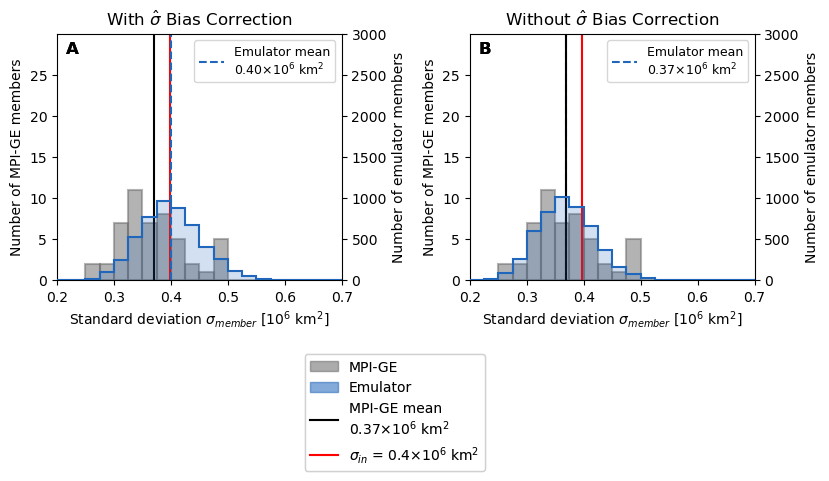

In [27]:
emulator_runs = 5000
#np.random.seed(6)
start, stop = 1979, 2024

bins = np.arange(0,1,0.025)
for scenario in ["ssp245", "ssp370", "ssp585"][:1]:
    fig, axs = plt.subplots(1,2, figsize=(4.5*2,3.2))#, constrained_layout=True)
    
    print(f"Mean:   {np.mean(Variability_MPI[scenario]):1.4f}")
    print(f"Median: {np.median(Variability_MPI[scenario]):1.4f}")

    for ax, sigma_correction in zip(axs, [True, False]):

        ax.set_xlabel(r"Standard deviation $\sigma_{member}$ [10$^6$ km$^2$]")

        ax.set_yticks([0,5,10,15, 20, 25])
        mean_std_time = np.mean(Variability_MPI[scenario])

        variability = em.experiment_indepth(members[0], df_co2, DF[scenario], emulator_runs, "ar1", start, stop, true_slope=MEANS[scenario]["sens"], amplitude=MEANS[scenario]["ensemble_spread"], ar1_corrcoef=MEANS[scenario]["ar1_coef"], co2_name=scenario, sigma_correction=sigma_correction, phi_correction=True)[4]
        plot_hist_comparision(Variability_MPI[scenario], variability, ax, bins, 30, emulator_runs)
        ax.axvline(x=MEANS[scenario]["ensemble_spread"], color="red")
        ax.axvline(x=np.mean(variability), label=f"Emulator mean\n{np.mean(variability):1.2f}×10$^6$ km$^2$", color="#2066BA", linestyle="--")
        ax.axvline(x=np.mean(Variability_MPI[scenario]), color="black")#, linestyle="--")

        print(np.mean(variability))

        ensemble_spread = MEANS[scenario]["ensemble_spread"]

        legend_elements = [Patch(color = "dimgray", label = "MPI-GE", alpha=0.5),
                            Patch(color = "#2066BA", label = "Emulator", alpha=0.5),
                            Line2D([0], [0], label=f"MPI-GE mean \n{np.mean(Variability_MPI[scenario]):1.2f}×10$^6$ km$^2$", color="black"),#, linestyle="--"
                            Line2D([0], [0], label=r"$\sigma_{in}$ "+f"= {ensemble_spread:1.2}×10$^6$ km$^2$", color="red")]

        lgd = fig.legend(loc='upper center',handles = legend_elements, bbox_to_anchor=(0.5, -0.1), ncol = 1)
        
        ax.set_xlim(0.2, 0.7)
        ax.legend(frameon=True, prop={'size':9})

        plt.subplots_adjust(wspace=0.45)
        for ax, letter in zip(axs,["A","B","C"]):
            ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)

    axs[0].set_title(r"With $\hat{\sigma}$ Bias Correction")
    axs[1].set_title(r"Without $\hat{\sigma}$ Bias Correction")

    hlp.save_plot(plotpath + f"MPI_Variability-by-member_{start}-{stop}_{scenario}", save_plots, ["png","pdf"])

    plt.show()

The spline based correction sucessfully translates between standard deviation estimated form a single time series versus standard deviation estimated from the member spread.

## AR1 Correlation Coeff

       Mean, std, IQR, Skewness, Kurtosis
data1: 0.466, 0.165, 0.212, -0.307, -0.140
data2: 0.465, 0.151, 0.210, -0.368, 0.078



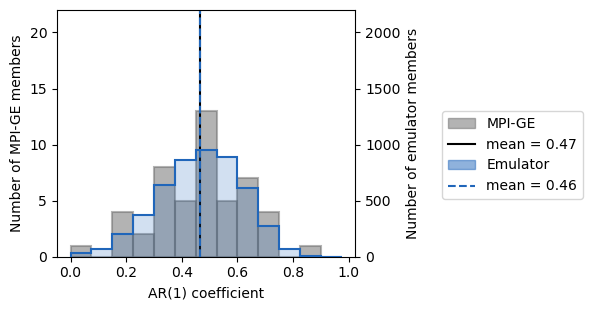

In [29]:
emulator_runs = 5000
bins = np.arange(0,1,0.075)

for scenario in ["ssp245", "ssp370", "ssp585"][:1]:
    fig, ax = plt.subplots(1,1, figsize=(4.4*1,3.2), tight_layout=True)

    ax.set_xlabel("AR(1) coefficient")

    mean_ar1_coef = MEANS[scenario]["ar1_coef"]#np.nanmean(AR1_coeff_MPI[se])
    ax.axvline(mean_ar1_coef, color="black")

    AR1_coeff = em.experiment_indepth(members[0], df_co2, DF[scenario], emulator_runs, "ar1", 1979, 2024, true_slope=MEANS[scenario]["sens"], amplitude=MEANS[scenario]["ensemble_spread"], ar1_corrcoef=MEANS[scenario]["ar1_coef"], co2_name=scenario, phi_correction=True)[3]
    plot_hist_comparision(AR1_coeff_MPI[scenario], AR1_coeff, ax, bins, 22, emulator_runs)
    print()
    ax.axvline(np.nanmean(AR1_coeff), color="#2066BA", linestyle="--")
    

    legend_elements = [Patch(color = "dimgray", label = "MPI-GE", alpha=0.5),
                       Line2D([0], [0], label=f"mean = {np.nanmean(AR1_coeff_MPI[scenario]):1.2f}", color="black"),
                           Patch(color = "#2066BA", label = "Emulator", alpha=0.5),
                           #
                           Line2D([0], [0], label=f"mean = {np.nanmean(AR1_coeff):1.2f}", color="#2066BA", linestyle="--")]

    lgd =  fig.legend(loc='center left', handles = legend_elements, bbox_to_anchor=(1, 0.5))

    hlp.save_plot(plotpath + f"MPI_AR1coef-by-time_{scenario}", save_plots, ["png","pdf"])
    

## Sensitivity Histograms

ssp245
       Mean, std, IQR, Skewness, Kurtosis
data1: -1.381, 0.262, 0.409, 0.297, -0.431
data2: -1.381, 0.145, 0.195, -0.010, -0.011
       Mean, std, IQR, Skewness, Kurtosis
data1: -1.381, 0.262, 0.409, 0.297, -0.431
data2: -1.381, 0.240, 0.325, -0.010, -0.005


/Users/quraus001/miniforge3/envs/emulator/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7096: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/quraus001/miniforge3/envs/emulator/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7097: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


plot was saved as: /Users/quraus001/Documents/Uni/Thesis/Paper/Rebuild-MPI-ESM-sens-hists.png
plot was saved as: /Users/quraus001/Documents/Uni/Thesis/Paper/Rebuild-MPI-ESM-sens-hists.pdf


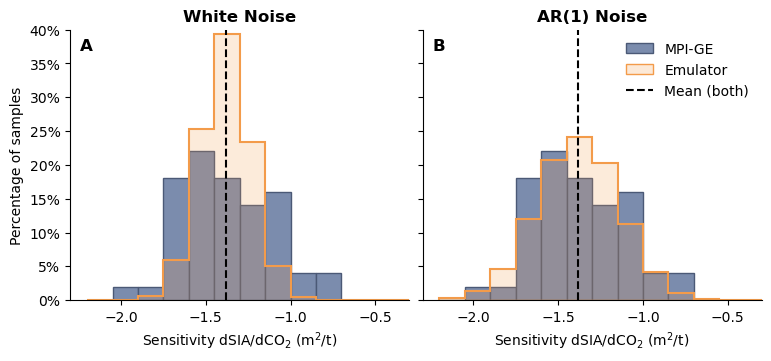

In [96]:
member=members[0]
seed = 10
runs = 100000
scenario="ssp245"
print(scenario)
from matplotlib.ticker import PercentFormatter
np.random.seed(seed)

params = {"member":members[0],
          "df_co2": df_co2,
          "df_sia": DF[scenario],
          "runs"  : runs,
          "observation_start": 1979,
          "observation_end"  : 2024,
          "true_slope": MEANS[scenario]["sens"],
          "amplitude" : MEANS[scenario]["ensemble_spread"],
          "ar1_corrcoef": MEANS[scenario]["ar1_coef"],
          "co2_name": scenario,
          "sigma_correction" : True,
          "noise_type" : "white",
          "phi_correction":True}
np.random.seed(seed)
Sensitivities_white = em.experiment(**params)[0]
params["noise_type"] = "ar1"
np.random.seed(seed)
Sensitivities_ar1 = em.experiment(**params)[0]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(3.8*2,3.5*1), sharey=True, constrained_layout=True)#5,4#

binwidth = 0.15
bins = np.arange(-2.2, 0.4 + binwidth, binwidth)

ax1.set_ylabel("Percentage of samples")



data1 = Obs_sens_MPI[scenario]

for ax, data2 in zip([ax1, ax2], [Sensitivities_white, Sensitivities_ar1]):
    ax.hist(data1, bins, weights=np.ones(len(data1)) / len(data1), color="#7B8CAD", edgecolor="#4B5976", label="MPI-GE")
    ax.hist(data2, alpha=1, bins=bins, histtype="step", color="#F39B4A", linewidth=1.5, weights=np.ones(len(data2)) / len(data2))
    ax.hist(data2, alpha=0.2, bins=bins, color="#F39B4A", weights=np.ones(len(data2)) / len(data2))

    print("       Mean, std, IQR, Skewness, Kurtosis")
    print(f"data1: {np.mean(data1):1.3f}, {np.std(data1):1.3f}, {stats.iqr(data1):1.3f}, {stats.skew(data1):1.3f}, {stats.kurtosis(data1):1.3f}")
    print(f"data2: {np.mean(data2):1.3f}, {np.std(data2):1.3f}, {stats.iqr(data2):1.3f}, {stats.skew(data2):1.3f}, {stats.kurtosis(data2):1.3f}")


    ax.set_xlim(-2.3,-0.3)
    ax.set_ylim(0, 0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    ax.set_xlabel("Sensitivity dSIA/dCO$_2$ (m$^2$/t)")
    ax.set_xticks(np.arange(-2,0,0.5))

for ax, letter in zip([ax1,ax2],["A","B"]):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)


#for ax, data in zip([ax1, ax2], [Sensitivities_white, Sensitivities_ar1]):
#    ax.hist(data, alpha=1, bins=bins, histtype="step", color="#F39B4A", linewidth=1.5, weights=np.ones(len(data)) / len(data))
#    ax.hist(data, alpha=0.2, bins=bins, color="#F39B4A", weights=np.ones(len(data)) / len(data))
ax2.hist([np.nan], bins, color="#F39C4A37", edgecolor="#F39B4A", label="Emulator")

ax1.axvline(x=np.mean(Obs_sens_MPI[scenario]), linestyle="--", color="black", label="Mean (both)")
ax2.axvline(x=np.mean(Obs_sens_MPI[scenario]), linestyle="--", color="black", label="Mean (both)")


ax1.set_title("White Noise", fontweight="bold")
ax2.set_title("AR(1) Noise", fontweight="bold")


ax2.legend(frameon=False)

hlp.save_plot("/Users/quraus001/Documents/Uni/Thesis/Paper/Rebuild-MPI-ESM-sens-hists", save_plots=True, file_types=["png","pdf"], dpi=300)
plt.show()



## Lin Timing

-1.3809452293289517 6.312807298780275
-1.2129668726091951 5.9834789548002485


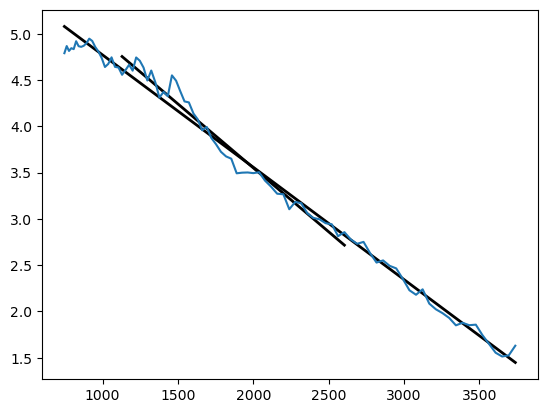

In [39]:
Lin_timings_MPI = []
Y_pred = []
Intercept = []
Sens = []
scenario = "ssp245"

start, stop = 1979, 2024

for mb in members:
    sens, y_pred, lin_timing, intercept = meta.get_meta_data(DF[scenario].loc[start:stop][mb].values, df_co2.loc[start:stop]["ssp245"].values)
    Lin_timings_MPI.append(lin_timing)
    Y_pred.append(y_pred)
    Intercept.append(intercept)
    Sens.append(sens)

    #plt.plot(df_co2.loc[start:stop]["ssp245"].values, y_pred)
print(np.mean(Sens), np.mean(Intercept))
plt.plot(df_co2.loc[start:stop][scenario].values, df_co2.loc[start:stop][scenario].values*np.mean(Sens)*1e-3 +np.mean(Intercept), color="black", lw=2)




if True:
    Lin_timings_MPI = []
    Y_pred = []
    Intercept = []
    Sens = []

    start, stop = 1959, 2050

    for mb in members:
        sens, y_pred, lin_timing, intercept = meta.get_meta_data(DF[scenario].loc[start:stop][mb].values, df_co2.loc[start:stop][scenario].values)
        Lin_timings_MPI.append(lin_timing)
        Y_pred.append(y_pred)
        Intercept.append(intercept)
        Sens.append(sens)

        #plt.plot(df_co2.loc[start:stop]["ssp245"].values, y_pred)
    print(np.mean(Sens), np.mean(Intercept))
    plt.plot(df_co2.loc[start:stop][scenario].values, df_co2.loc[start:stop][scenario].values*np.mean(Sens)*1e-3 +np.mean(Intercept), color="black", lw=2)
    plt.plot(df_co2.loc[start:stop][scenario].values, DF[scenario].loc[start:stop][ "mean"].values)


       Mean, std, IQR, Skewness, Kurtosis
data1: 3929.433, 450.252, 601.303, 1.073, 1.041
data2: 3756.264, 388.710, 466.003, 1.343, 4.071


LinAlgError: Matrix is not positive definite

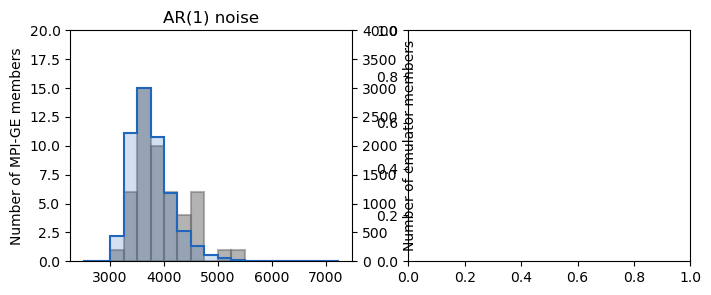

In [47]:
emulator_runs = 10000
scenario = "ssp245"

bins = np.arange(2500, 7500, 250)
ymax = 20

params = {"member":members[0],
          "df_co2": df_co2,
          "df_sia": DF[scenario],
          "runs"  : emulator_runs,
          "observation_start": 1979,
          "observation_end"  : 2024,
          "true_slope": MEANS[scenario]["sens"],
          "amplitude" : MEANS[scenario]["ensemble_spread"],
          "ar1_corrcoef": MEANS[scenario]["ar1_coef"],
          "co2_name": scenario,
          "sigma_correction" : True,
          "noise_type" : "ar1",
          "phi_correction":True}


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(4*2,3))#5,4#, constrained_layout=True

#Lin_timings_ar1 = em.experiment_indepth("mb091", df_co2, DF[scenario], emulator_runs, "ar1", 1979, 2022, true_slope=-1.41, amplitude=0.43, ar1_corrcoef=0.5, co2_name=scenario)[5]
Lin_timings_ar1 = em.experiment_indepth(**params)[5]
ax1_twin = plot_hist_comparision(Lin_timings_MPI[scenario], Lin_timings_ar1, ax1, bins, ymax, emulator_runs)
ax1.set_title("AR(1) noise")

#ax1.axvline(MEANS[scenario]["lin_timing"], color="black")
#ax1.axvline(np.nanmean(Lin_timings_ar1), color="#2066BA", linestyle="--")


params["noise_type"] = "cholesky"
params["sigma_correction"] = False
#Lin_timings_chol = em.experiment_indepth("mb091", df_co2, DF[scenario], emulator_runs, "cholesky", 1979, 2022, true_slope=-1.41, amplitude=0.43, ar1_corrcoef=0.5, co2_name=scenario, sigma_correction=False)[5]
Lin_timings_chol = em.experiment_indepth(**params)[5]
ax2_twin = plot_hist_comparision(Lin_timings_MPI[scenario], Lin_timings_chol, ax2, bins, ymax, emulator_runs)
ax2.set_title("Cholesky noise")

#ax2.axvline(MEANS[scenario]["lin_timing"], color="black")
#ax2.axvline(np.nanmean(Lin_timings_chol), color="#2066BA", linestyle="--")

for ax in [ax1, ax2]:
    ax.set_xlabel("Extrapolated timing [Gt]")

plt.subplots_adjust(wspace=0.55)

legend_elements = [Patch(color = "dimgray", label = "MPI-GE", alpha=0.5),
                   Patch(color = "#2066BA", label = "Emulator", alpha=0.5)]

lgd = ax2.legend(loc='upper right', handles = legend_elements, prop={'size':9})

for ax, letter in zip([ax1,ax2],["A","B"]):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)

hlp.save_plot(plotpath + "Rebuild-MPI-lintiming-hists", save_plots, ["png","pdf"])



## First Ice-Free Timing

       Mean, std, IQR, Skewness, Kurtosis
data1: 3732.488, 244.100, 343.036, -0.857, 0.630
data2: 3442.580, 216.270, 307.556, -0.331, 0.194
3442.5796956792474 2991.756587092607 3824.0202928926064
       Mean, std, IQR, Skewness, Kurtosis
data1: 3732.488, 244.100, 343.036, -0.857, 0.630
data2: 3370.645, 246.355, 308.507, -0.437, 0.371


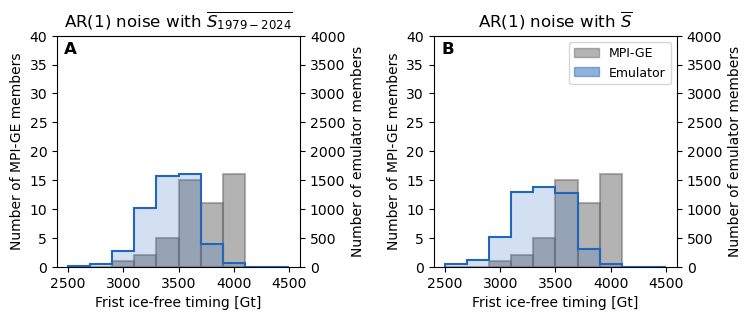

In [113]:
emulator_runs = 5000
IPR = 95.5
scenario = "ssp245"

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(4*2,3))#5,4#, constrained_layout=True
bins = np.arange(2500, 4600, 200)
#bins = np.arange(2000, 2100, 5)
ymax = 40

params = {"member":members[0],
          "df_co2": df_co2,
          "df_sia": DF[scenario],
          "runs"  : emulator_runs,
          "observation_start": 1979,
          "observation_end"  : 2024,
          "true_slope": MEANS[scenario]["sens"],
          "amplitude" : MEANS[scenario]["ensemble_spread"],
          "ar1_corrcoef": MEANS[scenario]["ar1_coef"],
          "co2_name": scenario,
          "sigma_correction" : True,
          "noise_type" : "ar1", 
          "prediction_end": 2099, 
          "df_co2_long": df_co2["ssp245"],
          "phi_correction":True}

#Sensitivities, *_, Lin_timing, EM_timing_year, EM_timing = em.experiment_indepth_long("mb091", df_co2, df, emulator_runs, "ar1", 1979, 2022, true_slope=-1.39, amplitude=0.43, ar1_corrcoef=0.5, co2_name=scenario, prediction_end=2099, df_co2_long=df_co2["ssp245"])
Sensitivities, *_, Lin_timing, EM_timing_year, EM_timing = em.experiment_indepth_long(**params)

ax1_twin = plot_hist_comparision(Sim_timings_MPI[scenario], EM_timing, ax1, bins, ymax, emulator_runs)
ax1.set_title(r"AR(1) noise with $\overline{S_{1979-2024}}$")

upper = np.percentile(EM_timing, 100 - (100-IPR)/2)
lower = np.percentile(EM_timing, (100-IPR)/2)
print(np.mean(EM_timing),lower, upper)


#params["true_slope"] = BS_both
params["amplitude"]  = MEANS[scenario]["ensemble_spread_end"]
Sensitivities, *_, Lin_timing, EM_timing_year, EM_timing = em.experiment_indepth_long(**params)
ax2_twin = plot_hist_comparision(Sim_timings_MPI[scenario], EM_timing, ax2, bins, ymax, emulator_runs)
ax2.set_title("AR(1) noise with $\overline{S}$")


for ax in [ax1, ax2]:
    ax.set_xlabel("Frist ice-free timing [Gt]")

fig.subplots_adjust(wspace=0.55)

legend_elements = [Patch(color = "dimgray", label = "MPI-GE", alpha=0.5),
                           Patch(color = "#2066BA", label = "Emulator", alpha=0.5)]



lgd = ax2.legend(loc='upper right', handles = legend_elements, prop={'size':9})

for ax, letter in zip([ax1,ax2],["A","B"]):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)

hlp.save_plot(plotpath + "Rebuild-MPI-simtiming-hists", save_plots, ["png","pdf"])

74
70
74
69
74
60
73
75
75
61
72
62
65
77
73
70
63
77
85
69
74
80
86
86
73
69
67
76
72
74
70
83
69
70
68
67
70
59
64
77
57
68
72
74
61
61
66
67
73
73
76
64
72
75
77
81
74
72
70
66
86
62
74
72
69
83
72
64
67
72
53
61
85
78
72
71
86
75
68
66
81
72
71
57
75
77
78
64
64
70
69
69
80
60
78
77
63
67
63
64


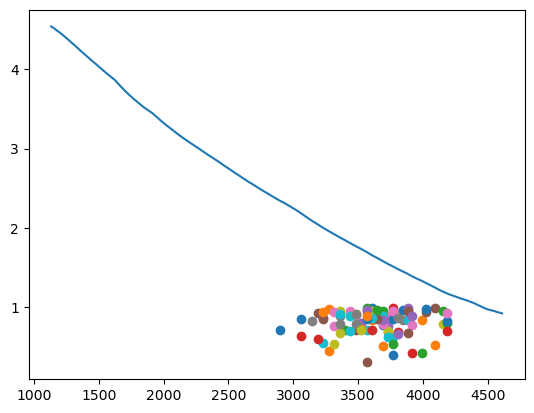

In [ ]:
for member in members[:]:
    #plt.plot(df_co2["ssp245"].loc[1979:2099], DF["ssp245"][member].loc[1979:2099])
    ice_free_index = meta.find_icefree_idx(DF["ssp245"][member].loc[1979:2099], amount_icefree=1, threshold_value=1)
    #print(ice_free_index)
    plt.scatter([df_co2["ssp245"].loc[1979:2099].iloc[ice_free_index]], [DF["ssp245"][member].loc[1979:2099].iloc[ice_free_index]], alpha=1)

plt.plot(df_co2["ssp245"].loc[1979:2099], df_co2["ssp245"].loc[1979:2099] * -1.)
plt.plot(df_co2["ssp245"].loc[1979:2099], DF["ssp245"]["rolling"].loc[1979:2099])

## Bar Plots

In [98]:
def test_range(var, noise, emulator_runs=10000, scenario = "ssp245", to_test=None, ranges = [68.3, 95.5, 99.7], sigma_increase_correction=None, slope_correction = None, phi_correction=True, sigma_correction=True):

    Upper, Lower = {}, {}
    cnt = 0

    for IPR in ranges:
        Upper[IPR], Lower[IPR] = {}, {}

    for observed_member in tqdm(members[:], leave=True):
        if var == "sens":
            Var = em.experiment(observed_member, df_co2, DF[scenario], emulator_runs, noise, 1979, 2024, co2_name=scenario, phi_correction=True, sigma_correction=sigma_correction)[0]
        elif var == "timing":
            Var = em.experiment_indepth(observed_member, df_co2, DF[scenario], emulator_runs, noise, 1979, 2024, co2_name=scenario, phi_correction=True, sigma_correction=sigma_correction)[5]
        elif var == "first_timing":
            Var = em.experiment_indepth_long(observed_member, df_co2, DF[scenario], emulator_runs, noise, 1979, 2024, co2_name=scenario, 
                                             prediction_end=2300, df_co2_long=df_co2[scenario], sigma_increase_correction=sigma_increase_correction, slope_correction = slope_correction, phi_correction=phi_correction, sigma_correction=sigma_correction)[7]
        else:
            print(f"Testing not defined for {var}")

        for IPR in ranges:
            upper = np.percentile(Var, 100 - (100-IPR)/2)
            lower = np.percentile(Var, (100-IPR)/2)
            Upper[IPR][observed_member] = upper
            Lower[IPR][observed_member] = lower

            #if observed_member == 'mb072':
            #    print(upper, lower)
            #    plt.hist(Var)

        
        if to_test is not None:
            #print(Upper[95.5][observed_member],Upper[95.5][observed_member])
            #print(to_test < Upper[95.5][observed_member] and to_test > Upper[95.5][observed_member])
            if to_test < Upper[95.5][observed_member] and to_test > Lower[95.5][observed_member]:
                cnt+=1

    print(cnt)
    return Upper, Lower

In [99]:
def plot_bars_single(Upper, Lower, to_test, IPR, ax=None, xlabel = "", plotting=True):

    cnt, above, below = 0, 0, 0

    for i, observed_member in enumerate(members[:]):
        upper = Upper[observed_member]
        lower = Lower[observed_member]

        if to_test <= upper and to_test >= lower:
            color="green"
            cnt+=1
        else:
            if to_test > upper:
                above +=1
            elif to_test < lower:
                below +=1
            color="red"
        #print(lower, upper)
        if plotting:
            ax.barh(i+1, upper-lower, align='center', color=color, left=lower, height=0.3, alpha=0.5, edgecolor=color)
    if plotting:
        ax.set_ylabel("MPI-GE Member")
        #ax.set_title(f"{sigma_range}$\sigma$ Spread")

        # Extract the integer part
        integer_part = int(IPR)

        # Create a string with LaTeX-like subscripts for each digit of the integer part
        subscript_str = ''.join(f"$_{digit}$" for digit in str(integer_part))

        ax.axvline(x=to_test, linestyle="--", color="grey", label=f"MPI-GE mean sensitivity")
        ax.plot(np.nan, color="green", label=f"within IPR{subscript_str}", alpha=0.5)
        ax.plot(np.nan, color="white", label=f"{cnt} members inside", alpha=0.5)
        ax.plot(np.nan, color="red", label=f"outside IPR{subscript_str}", alpha=0.5)

        left, bottom, width, height = (0.74, 0.9, 0.25, 0.1)
        rect = plt.Rectangle((left, bottom), width, height,
                        facecolor="lightgrey", alpha=0.7, transform=ax.transAxes, zorder=9)

        ax.add_patch(rect)
        ax.set_title(f"IPR{subscript_str}")
        ax.text(0.76, 0.91, f"{cnt:.0f} hits \n {cnt/50*100}%", transform=ax.transAxes,  zorder=10 )
        
        #ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
        ax.margins(y=0.01)

        ax.set_xlabel(xlabel)
        #ax.legend()
    print(f"inside: {cnt}, above: {above}, below: {below}")
    #ax.set_ylim(0,101)
    #ax.set_yticks([1, 20, 40, 60, 80, 100])

    return

In [103]:
def plot_bars_combined(Upper, Lower, var, noise, to_test, IPRs=[68.3, 95.5, 99.7], plotting=True, name_add_on=""):
    print(f"testing for {to_test}")
    xlabels = {"sens": "Sensitivity [m$^2$/t CO$_2$]", "timing": "Extrapolated timing [Gt]", "first_timing": "First ice-free timing [Gt]"}

    Letters = list(string.ascii_uppercase)[:len(IPRs)]
    left, bottom, width, height = (0.01, 0.91, 0.15, 0.08)

    fig, axs = plt.subplots(1,3, constrained_layout=True, figsize=(3*3,4.5))


    for ax, IPR, letter in zip(axs, IPRs, Letters):
        plot_bars_single(Upper[IPR], Lower[IPR], to_test, IPR, ax = ax, xlabel=xlabels[var], plotting=plotting)

        rect = plt.Rectangle((left, bottom), width, height, facecolor="white", alpha=0.5, transform=ax.transAxes, zorder=9)
        ax.add_patch(rect)
        ax.text(.05, .95, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)
        if var == "timing":
            ax.set_xlim(0,10000)

    legend_elements = [Line2D([0], [0], label=f"MPI-GE mean", color="grey", linestyle="--", alpha=0.5),
                   #Line2D([0], [0], label=f"biased shifted", color="grey", linestyle="--", alpha=0),
                   Line2D([0], [0], label=f"inside IPR", color="green", alpha=0.5),
                   Line2D([0], [0], label=f"outside IPR", color="red", alpha=0.5),]

    lgd =  fig.legend(loc='lower center', handles = legend_elements, bbox_to_anchor=(0.53, -0.25))

    
    if var=="sens":
        hlp.save_plot(plotpath + f"EM-mpi-bar-{noise}_{var}_{emulator_runs}runs_{to_test:.2f}tested{name_add_on}", save_plots, ["png","pdf"])
    else:
        hlp.save_plot(plotpath + f"EM-mpi-bar-{noise}_{var}_{emulator_runs}runs_{to_test:.0f}tested{name_add_on}", save_plots, ["png","pdf"])


### Sensitivity

#### AR(1)

In [79]:
emulator_runs = 10000
variable = "sens"
noise    = "ar1"
scenario = "ssp370"
Upper_sens, Lower_sens= test_range(variable, noise, emulator_runs=emulator_runs, scenario = scenario, to_test=-1.39, phi_correction=True)

100%|██████████| 50/50 [01:49<00:00,  2.19s/it]

45


In [107]:
emulator_runs = 10000
variable = "sens"
noise    = "ar1"
scenario = "ssp245"
Upper_sens, Lower_sens= test_range(variable, noise, emulator_runs=emulator_runs, scenario = scenario, to_test=-1.39, phi_correction=True)

100%|██████████| 50/50 [01:48<00:00,  2.17s/it]

41


In [108]:
BS_all = (MEANS["ssp245"]["background_sens"] + MEANS["ssp585"]["background_sens"] + MEANS["ssp370"]["background_sens"])/3

testing for -1.2279359735197735
inside: 26, above: 19, below: 5
inside: 39, above: 9, below: 2
inside: 46, above: 4, below: 0


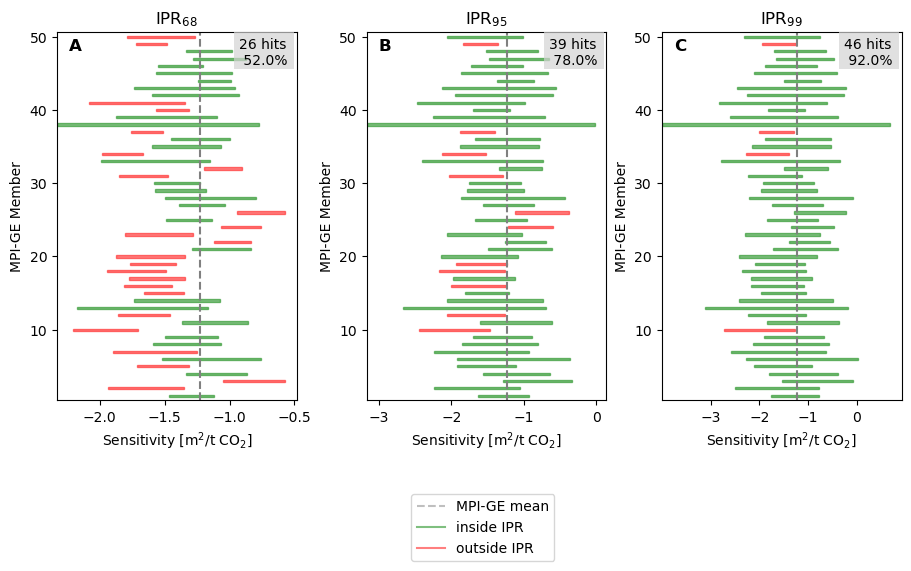

In [109]:
plot_bars_combined(Upper_sens, Lower_sens, variable, noise, to_test=BS_all)

In [111]:
MEANS[scenario]

{'sens': np.float64(-1.3809452293289517),
 'background_sens': np.float64(-1.2543270594502718),
 'ar1_coef': np.float64(0.4662448448235721),
 'member_std': np.float64(0.36964391416152276),
 'lin_timing': np.float64(3929.4330085132838),
 'sim_timing': np.float64(3732.488304058607),
 'sim_timing_year': 2049,
 'ensemble_spread': np.float32(0.39785302),
 'ensemble_spread_end': np.float32(0.46776944)}

testing for -1.2543270594502718
inside: 26, above: 18, below: 6
inside: 41, above: 7, below: 2
inside: 47, above: 3, below: 0


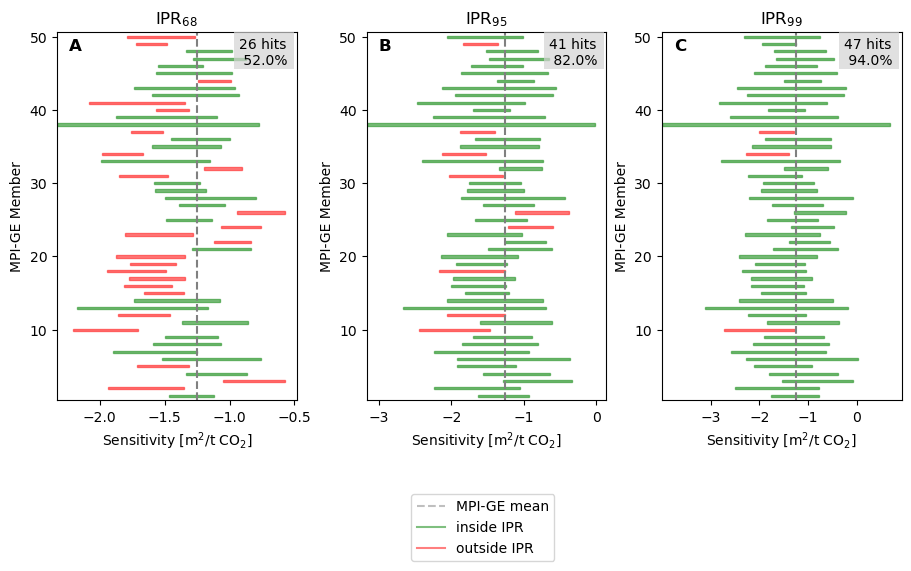

In [112]:
plot_bars_combined(Upper_sens, Lower_sens, variable, noise, to_test=MEANS[scenario]["background_sens"])

testing for -1.3809452293289517
inside: 30, above: 9, below: 11
inside: 41, above: 3, below: 6
inside: 47, above: 1, below: 2


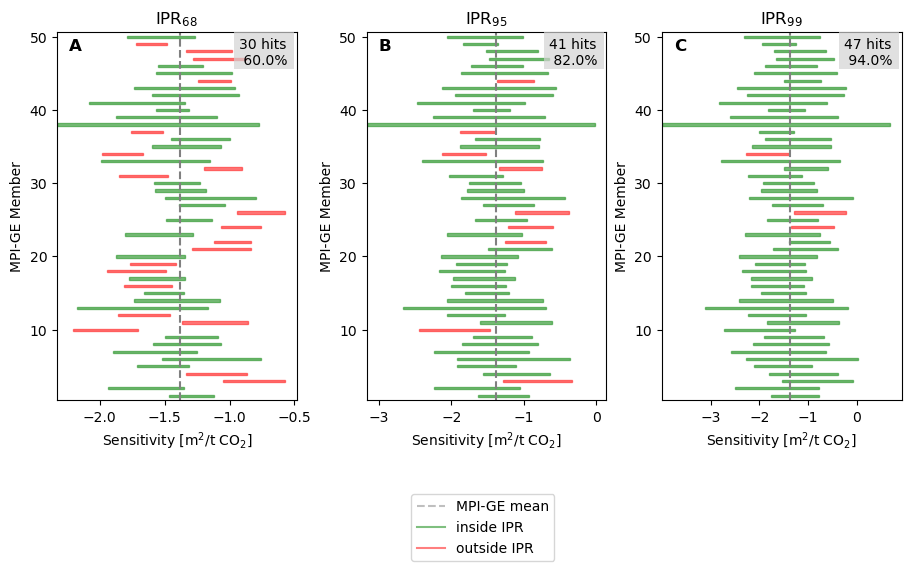

In [110]:
plot_bars_combined(Upper_sens, Lower_sens, variable, noise, to_test=MEANS[scenario]["sens"])

testing for -1.3544649007369178
inside: 31, above: 10, below: 9
inside: 45, above: 2, below: 3
inside: 45, above: 2, below: 3


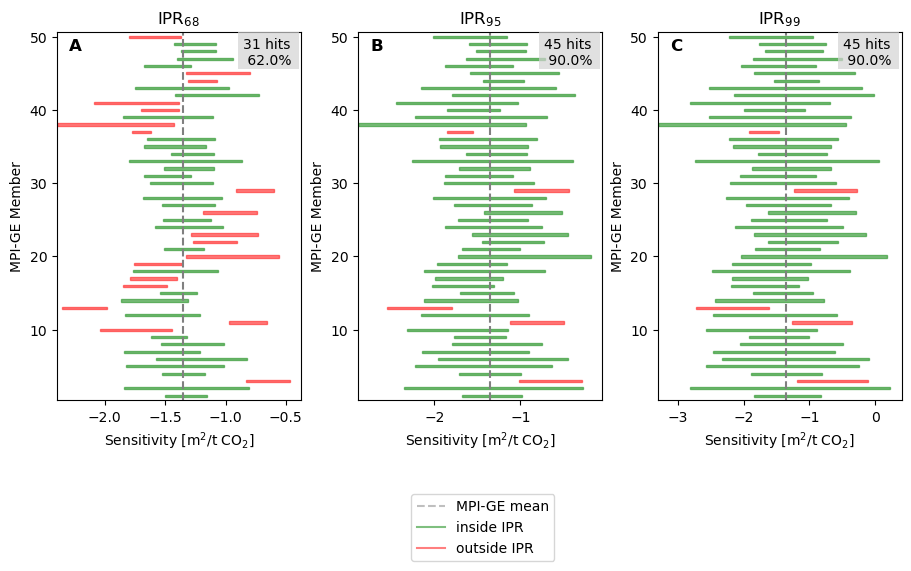

In [64]:
plot_bars_combined(Upper_sens, Lower_sens, variable, noise, to_test=MEANS[scenario]["sens"])

testing for -1.3809452293289517
inside: 30, above: 9, below: 11
inside: 41, above: 3, below: 6
inside: 48, above: 0, below: 2


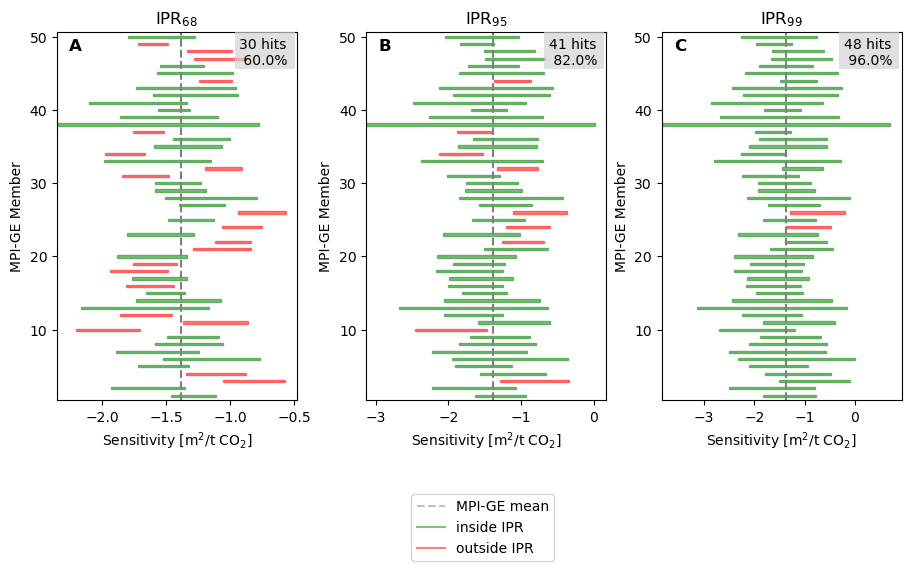

In [62]:
plot_bars_combined(Upper_sens, Lower_sens, variable, noise, to_test=MEANS[scenario]["sens"])

### Extrapolated Timing

#### AR(1)

In [69]:
emulator_runs = 5000
variable = "timing"
noise    = "ar1"
scenario = "ssp370"
Upper_lin_timing, Lower_lin_timing = test_range(variable, noise, emulator_runs=emulator_runs, scenario = scenario, to_test=MEANS[scenario]["lin_timing"])

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]

44


testing for 3929.4330085132838
inside: 30, above: 12, below: 8
inside: 42, above: 3, below: 5
inside: 49, above: 1, below: 0


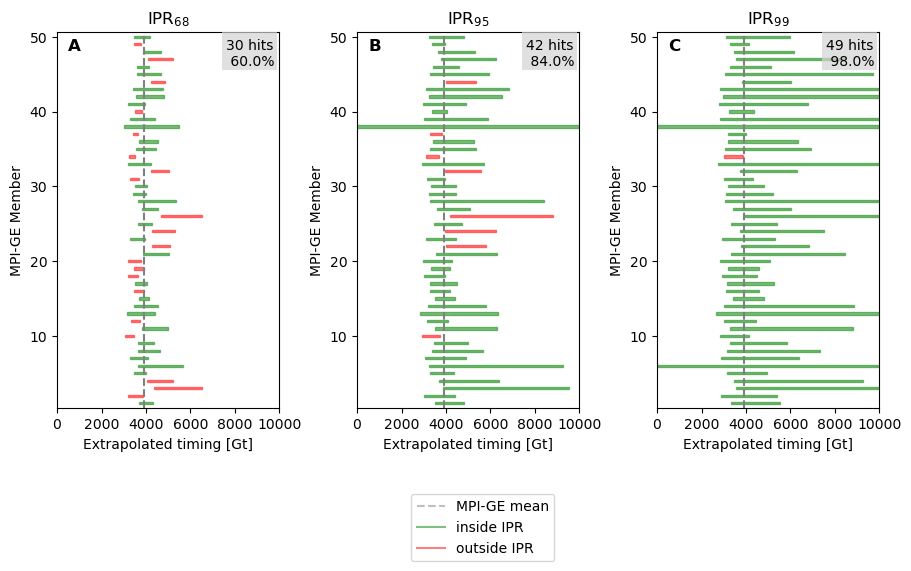

In [68]:
plot_bars_combined(Upper_lin_timing, Lower_lin_timing, variable, noise, to_test=MEANS[scenario]["lin_timing"])

testing for 3992.5890142719636
inside: 33, above: 11, below: 6
inside: 44, above: 3, below: 3
inside: 45, above: 2, below: 3


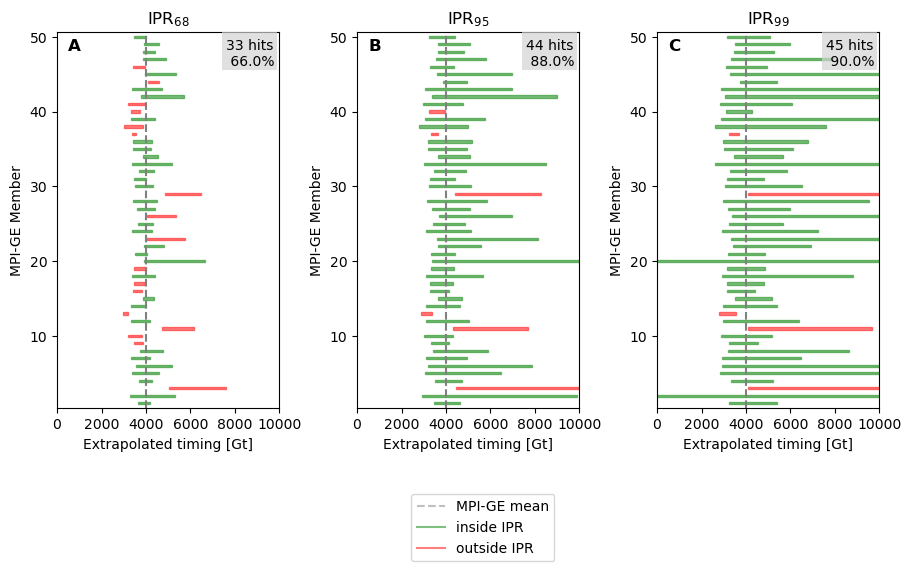

In [70]:
plot_bars_combined(Upper_lin_timing, Lower_lin_timing, variable, noise, to_test=MEANS[scenario]["lin_timing"])

### First Ice-Free Timing

In [73]:
emulator_runs = 5000
variable = "first_timing"
noise    = "ar1"
scenario = "ssp370"
Upper_first_timing, Lower_first_timing = test_range(variable, noise, emulator_runs=emulator_runs, scenario = scenario, to_test=3639)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:53<00:00,  2.28s/it]

43


In [41]:
MEANS[scenario]["sim_timing"]

3489.7591865463996

testing for 3898.395528676606
inside: 18, above: 24, below: 8
inside: 38, above: 9, below: 3
inside: 43, above: 4, below: 3


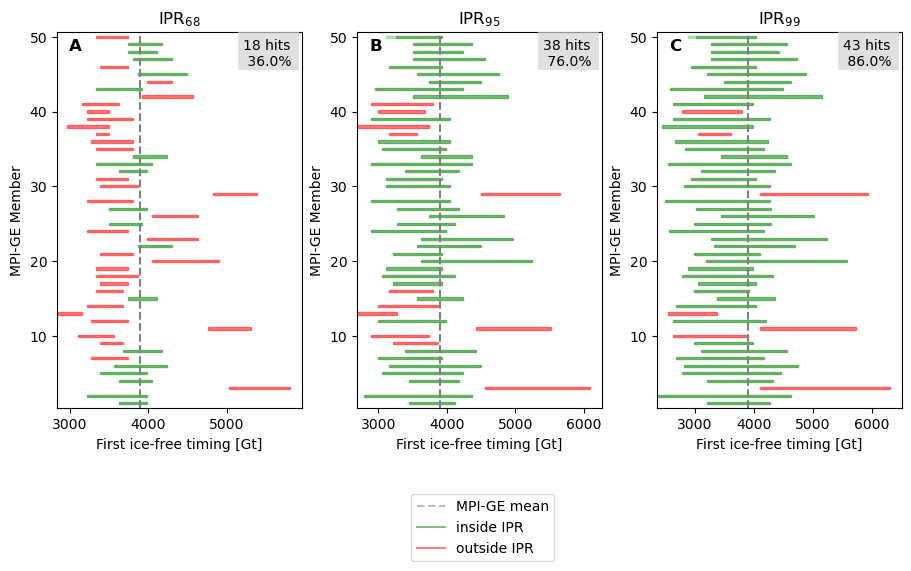

In [74]:
plot_bars_combined(Upper_first_timing, Lower_first_timing, variable, noise, to_test=MEANS[scenario]["sim_timing"])#MEANS[scenario]["sim_timing"])